# Machine Learning Final Project - Rizky Maulana Saputra

## Data Understanding

Dataset yang digunakan adalah hasil scraping dari google playstore review. Dataset ini memiliki 10.000 baris dan 11 kolom daya yang mempresentasikan :
- review_id : Id user google playstore
- userName : Username dari user google playstore
- userImage : Photo Profile dari user google playstore
- content : Isi Komentar dari user google playstore
- score : Rating dari user google playstore ke appsnya
- thumbsUpCount : Like / thumbsup dari user yang lain
- reviewCreatedVersion : versi apps ketika terdapat review
- at : Waktu melakukan review oleh user google playstore
- replyContent : Reply atau jawaban dari developer terkait review yang diberikan user google playstore
- repliedAt : Waktu ketika developer me reply atau menjawab review user google play store 
- appVersion : versi aplikasi 

- import library

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelEncoder
from sklearn.svm import LinearSVC
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
import nltk
import csv
import requests
from io import  StringIO
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

- load data

In [77]:
df = pd.read_csv('../ulasan_x.csv')

In [78]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,aaf69c9e-8b40-4467-8abd-cb008ccbe1ba,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"udah update, postingan mutual saya masih serin...",1,821,11.0.0-release.0,2025-05-26 18:55:34,NaN,NaN,11.0.0-release.0
1,2a462232-d4b4-4c78-88d1-1c479bcf60de,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"tolong Kepada Pihak Aplikasi X, Saya mohon per...",1,129,11.0.0-release.0,2025-05-23 15:11:16,NaN,NaN,11.0.0-release.0
2,adefde72-bbfa-4826-8c20-f5684159bb07,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"pas buka dm di refresh gak bisa, liat postinga...",1,68,11.0.0-release.0,2025-05-23 12:33:47,NaN,NaN,11.0.0-release.0
3,c3453f6d-70e9-4d26-bf3b-1db3e064f77c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"apa² nih, kok makin lemot gini sih, wifi ada k...",1,63,11.0.0-release.0,2025-05-24 20:25:19,NaN,NaN,11.0.0-release.0
4,e4af7ac3-88d0-4192-a503-ca44a8575853,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,X nih kenapa akhir² ini sering error? udah 1 m...,1,54,11.0.0-release.0,2025-05-26 20:55:05,NaN,NaN,11.0.0-release.0


## Exploratory Data Analytics

In [79]:
df.dtypes

reviewId                 object
userName                 object
userImage                object
content                  object
score                     int64
thumbsUpCount             int64
reviewCreatedVersion     object
at                       object
replyContent            float64
repliedAt               float64
appVersion               object
dtype: object

In [80]:
df.isna().sum()

reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion     2475
at                          0
replyContent            10000
repliedAt               10000
appVersion               2475
dtype: int64

In [81]:
df.duplicated().sum()

0

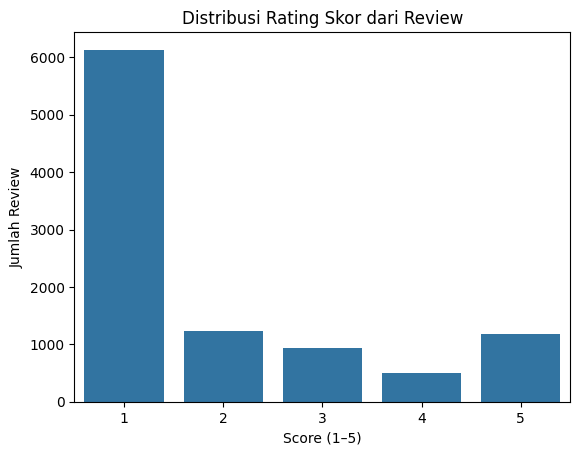

In [82]:
sns.countplot(x='score', data=df)
plt.title('Distribusi Rating Skor dari Review')
plt.xlabel('Score (1–5)')
plt.ylabel('Jumlah Review')
plt.show()

## Data Preparation

In [83]:
pd.options.mode.chained_assignment = None
seed=0
np.random.seed(seed)
# tokenizer berbasis punctuation (titik, koma, dll)
nltk.download('punkt')
# daftar stopword bahasa inggris
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

1. Drop fitur yang tidak digunakan

In [84]:
df = df.drop(columns=['replyContent', 'repliedAt', 'reviewCreatedVersion', 'appVersion', 'userImage'])

2. Melakukan cleaning text di kolom content :
   - Menghapus mention, hashtag, URL, simbol, angka, newline, dan tanda baca
   - Mengubah teks jadi huruf kecil semua
   - Memecah kalimat jadi list kata
   - Mengapus stopword (kata kata umum yang tidak memiliki makna penting)
   - Mengubah kata ke bentuk dasar menggunakan Sastrawi Stemmer
   - Standarisasi kata kata gaul/slang ke bentuk formal
   - Membuat list kata menjadi satu kalimat

In [85]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text) 
    text = re.sub(r'RT[\s]', '', text) 
    text = re.sub(r"http\S+", '', text) 
    text = re.sub(r'[0-9]+', '', text) 
    text = re.sub(r'[^\w\s]', '', text) 
    text = text.replace('\n', ' ') 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.strip(' ') 
    return text
def casefoldingText(text): 
    text = text.lower()
    return text
def tokenizingText(text): 
    text = word_tokenize(text)
    return text
def filteringText(text): 
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','gue','lu','loe','lo','kok','lah',
    'nih','tuh','dong','aja','deh','kan','lah','lahh','lho','loh','yee','ya',
    'ga','gaa','gitu','gini','wkwk','wkwkwk','haha','hehe','anjay','anjir','woi','woii','woy',
    'btw','banget','bang','min','admin','mantul','top','sip','oke','ok','kak',
    'bro','sis','cuy','gan','om','bos','bosque','ciyus','serius','wow','mantap',
    'terbaik','bagus','jelek','parah','ampas','fix','the','best','lol','lmao'])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def stemmingText(text): 
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text
def toSentence(list_words): 
    sentence = ' '.join(word for word in list_words)
    return sentence

slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual",
    "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "dr": "dari", "yg": "yang",
    "tdk": "tidak", "udh": "sudah", "blm": "belum", "dgn": "dengan",
}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [86]:

df['text_clean'] = df['content'].apply(cleaningText)
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)
df['text_akhir'] = df['text_stopword'].apply(toSentence)

3. Membuat fitur baru yaitu polarity yang berisi kategori negative, netral, positive :
   - Mengambil data Lexicon(kumpulan kata yang memiliki makna) Positive dan Negative dari github
   - Memisahkan per kategori berdasarkan score yang dimana score tersebut ada di github

In [87]:
lexicon_positive = dict()

response_positive = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response_positive.status_code == 200:
    reader = csv.reader(StringIO(response_positive.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print('Failed to fetch positive lexicon data')

lexicon_negative = dict()

response_negative = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response_negative.status_code == 200:
    reader = csv.reader(StringIO(response_negative.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print('Failed to fetch negative lexicon data')


def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity = ''
    if (score>0):
        polarity = 'positive'
    elif(score<0):
        polarity = 'negative'
    else:
        polarity = 'netral'
    return score, polarity

results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

polarity
negative    6446
positive    2589
netral       965
Name: count, dtype: int64


4. Visual WordCloud terkait perseberan positive, negative dan netral

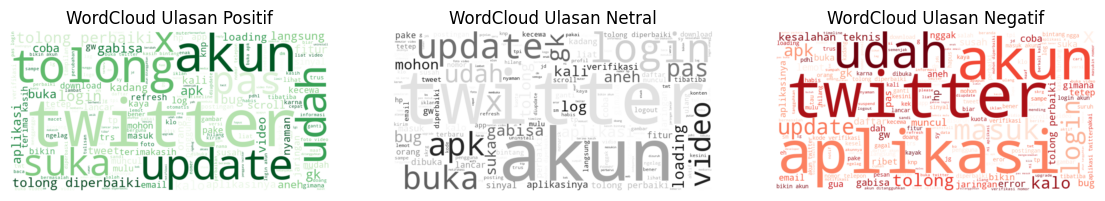

In [88]:
positive_words = ' '.join(df[df['polarity'] == 'positive']['text_akhir'].astype(str))
negative_words = ' '.join(df[df['polarity'] == 'negative']['text_akhir'].astype(str))
netral_words = ' '.join(df[df['polarity'] == 'netral']['text_akhir'].astype(str))

wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_words)

wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_words)

wordcloud_netral = WordCloud(width=800, height=400, background_color='white', colormap='Greys').generate(netral_words)

plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Positif')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Netral')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Negatif')



plt.show()

5. Splitting Data

- Machine Learning

In [89]:
X = df['text_akhir']
y = df['polarity']

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

- Deep Learning

In [90]:
# Tokenizing
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text_akhir'])
sequences = tokenizer.texts_to_sequences(df['text_akhir'])

# Menyamakan panjang data
maxlen = 200
X_padded = pad_sequences(sequences, maxlen=maxlen)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['polarity'])

# Split
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)



## Modelling

1. Machine Learning pakai SVC

In [91]:
model_ls = LinearSVC()
model_ls.fit(X_train_ml, y_train_ml)
y_pred_ls = model_ls.predict(X_test_ml)
print(classification_report(y_test_ml, y_pred_ls))

              precision    recall  f1-score   support

    negative       0.89      0.96      0.93      1285
      netral       0.63      0.35      0.45       198
    positive       0.83      0.82      0.83       517

    accuracy                           0.86      2000
   macro avg       0.79      0.71      0.73      2000
weighted avg       0.85      0.86      0.85      2000



2. Deep Learning pakai GRU

In [92]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    GRU(32, return_sequences = False),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, maxlen))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,297,859 (4.95 MB)

 Trainable params: 1,297,859 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
callbacks_model = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1),
]

In [94]:
history = model.fit(X_train_dl, y_train_dl, validation_data=(X_test_dl, y_test_dl),epochs=50, batch_size=64, callbacks=callbacks_model)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.6497 - loss: 0.8768 - val_accuracy: 0.8050 - val_loss: 0.5098 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8679 - loss: 0.3509 - val_accuracy: 0.8545 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9308 - loss: 0.1859 - val_accuracy: 0.8530 - val_loss: 0.4401 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9599 - loss: 0.1142 - val_accuracy: 0.8480 - val_loss: 0.4855 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9711 - loss: 0.0842
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9711 - loss: 0.0843 - val_accuracy: 0.8385 - val_loss: 0.5533 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9805 - loss: 0.

## Evaluation

1. Confusion Matrix dari Machine Learning

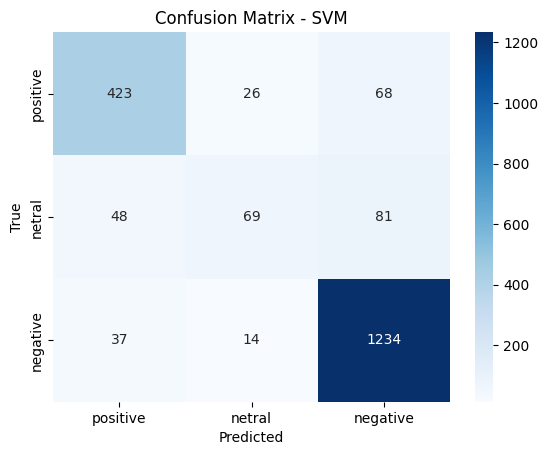

In [95]:
cm = confusion_matrix(y_test_ml, y_pred_ls, labels=['positive', 'netral', 'negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'netral', 'negative'], yticklabels=['positive', 'netral', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show()

2. Visual terkait train per epoch

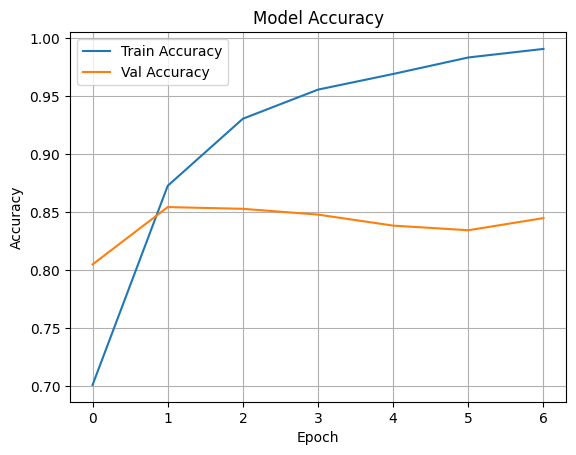

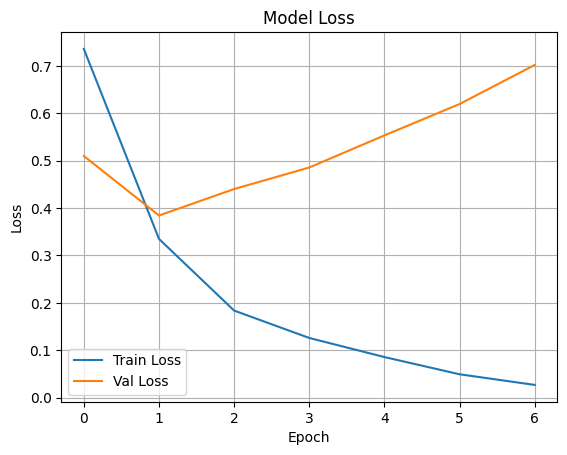

In [96]:
# Akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


3. Confusion Matrix dari Deep Learning

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


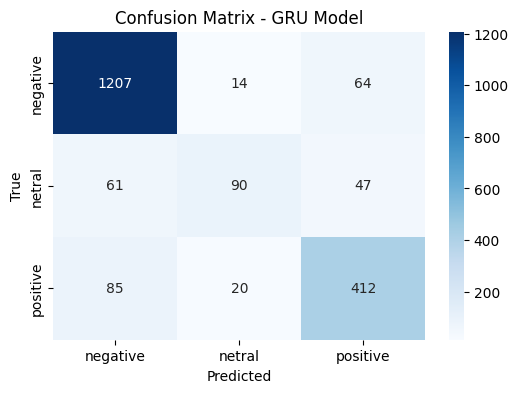

In [97]:
y_pred_dl = model.predict(X_test_dl)
y_pred_classes = np.argmax(y_pred_dl, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_dl, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GRU Model')
plt.show()

## Conclusion

Berdasarkan hasil evaluasi performa klasifikasi sentimen menggunakan confusion matrix, diperoleh beberapa temuan penting dari kedua model yang diuji, yaitu Support Vector Machine (SVM) dan Gated Recurrent Unit (GRU):

1. Model SVM menunjukkan performa yang sangat baik dalam mengklasifikasikan sentimen negatif, dengan jumlah prediksi benar sebanyak 1.234 dari 1.285 data, menunjukkan akurasi tinggi pada kelas tersebut. Namun demikian, performa SVM terhadap kelas netral relatif rendah dengan hanya 69 prediksi benar dari 198 data. Hal ini menunjukkan bahwa SVM cenderung lebih bias terhadap kelas mayoritas, khususnya kelas negatif.

2. Model GRU memberikan hasil yang lebih seimbang dibandingkan SVM. Meskipun akurasi pada kelas negatif sedikit lebih rendah dibandingkan SVM (1.178 dari 1.285 data), model ini menunjukkan peningkatan akurasi pada kelas netral sebesar 88 prediksi benar dari 198 data. Selain itu, akurasi pada kelas positif juga tetap kompetitif, dengan 418 prediksi benar dari 517 data.

3. Secara keseluruhan, model GRU mampu memberikan hasil klasifikasi yang lebih merata pada ketiga kelas sentimen (positif, netral, dan negatif), sementara model SVM cenderung memiliki performa yang sangat dominan pada kelas negatif tetapi lemah pada kelas netral.

## Testing

In [98]:
test_text = ["Aplikasi Jelek"]

# Baru di-preprocessing
clean = [cleaningText(t) for t in test_text]
casefold = [casefoldingText(t) for t in clean]
slangfix = [fix_slangwords(t) for t in casefold]
token = [tokenizingText(t) for t in slangfix]
filtered = [filteringText(t) for t in token]
sentence = [toSentence(t) for t in filtered]

# TF-IDF Model (SVM)
X_test = tfidf.transform(sentence)
prediction_svm = model_ls.predict(X_test)

# GRU Model
X_test_seq = tokenizer.texts_to_sequences(sentence)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)
prediction_dl = model.predict(X_test_pad)
label_dl = np.argmax(prediction_dl, axis=1)

print("SVM Prediction:", prediction_svm[0])
print("GRU Prediction:", label_dl[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
SVM Prediction: negative
GRU Prediction: 0


In [99]:
test_text = ["Apps ini sangat menyenangkan"]

# Baru di-preprocessing
clean = [cleaningText(t) for t in test_text]
casefold = [casefoldingText(t) for t in clean]
slangfix = [fix_slangwords(t) for t in casefold]
token = [tokenizingText(t) for t in slangfix]
filtered = [filteringText(t) for t in token]
sentence = [toSentence(t) for t in filtered]

# TF-IDF Model (SVM)
X_test = tfidf.transform(sentence)
prediction_svm = model_ls.predict(X_test)

# GRU Model
X_test_seq = tokenizer.texts_to_sequences(sentence)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)
prediction_dl = model.predict(X_test_pad)
label_dl = np.argmax(prediction_dl, axis=1)

print("SVM Prediction:", prediction_svm[0])
print("GRU Prediction:", label_dl[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
SVM Prediction: positive
GRU Prediction: 2
